---
##### **Identifikasi Variabel Ekologis Paling Signifikan terhadap Tingkat Morbiditas Demam Berdarah Dengue di Jawa Tengah sebagai Landasan Strategi Mitigasi Menggunakan Random Forest**

Kelompok 4 :
1. Darmayanti - F1G123004
2. Muhammad Syahrul Mubarak - F1G123030

#### **Merancang pertanyaan yang relevan untuk bisnis atau analisis**

1.
2.

#### **Deskripsi Proyek : **
---


#### **Persiapan environment sistem**
---


#### **Import Libraries**

Tahap ini adalah pemanggilan pustaka (libraries) Python yang diperlukan untuk manipulasi data, visualisasi, dan pemodelan mesin. Memastikan semua fungsi analisis data dan algoritma Random Forest tersedia untuk digunakan.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
print("Library berhasil di-import!")

Library berhasil di-import!


---
#### **Data Accessing**

roses memuat data mentah dari sumber eksternal (file CSV) ke dalam struktur data yang dapat diolah (Dataframe). Mendapatkan akses penuh terhadap variabel ekologis (Hujan, Sampah, Penduduk, Sanitasi) untuk diproses.

---

In [2]:
# Ganti nama file di bawah ini jika berbeda dengan file di folder Anda
df_dbd = pd.read_csv('data_dbd.csv').rename(columns={'tahun_data':'Tahun', 'kab_kota':'Kabupaten/Kota', 'jumlah':'kasus_dbd'})
df_hujan = pd.read_csv('curah_hujan_fix.csv').rename(columns={'jumlah (mm)':'curah_hujan_mm', 'Kabupaten/Kota':'Kabupaten/Kota'})
df_sampah = pd.read_csv('pengelolaan_sampah_fix.csv').rename(columns={'tahun_data':'Tahun', 'kab_kota':'Kabupaten/Kota', 'jumlah':'timbulan_sampah_ton'})
df_penduduk = pd.read_csv('persentase_penduduk.csv').rename(columns={'Kabupaten/Kota':'Kabupaten/Kota'})
df_sanitasi = pd.read_csv('sanitasi.csv').rename(columns={'Kabupaten/Kota':'Kabupaten/Kota', 'Rumah Tangga yang Memiliki Akses Terhadap Sanitasi Layak':'akses_sanitasi_layak_persen'})

print("Data Accessing Selesai. Data mentah berhasil dimuat.")

Data Accessing Selesai. Data mentah berhasil dimuat.


---
#### **Data Inspection (Inspeksi Data)**

Menampilkan beberapa baris pertama dari dataset mentah. Memastikan data terbaca dengan benar dan melihat nama kolom aslinya.

---

In [3]:
print("--- Sampel Data DBD ---")
display(df_dbd.head(3))
print("\n--- Sampel Data Curah Hujan ---")
display(df_hujan.head(3))

--- Sampel Data DBD ---


,Tahun,Kabupaten/Kota,kasus_dbd,jumlah_meninggal
0,2019,Kab.Cilacap,476,9
1,2019,Kab.Banyumas,202,12
2,2019,Kab.Purbalingga,502,6



--- Sampel Data Curah Hujan ---


,Tahun,Kabupaten/Kota,curah_hujan_mm
0,2019,Kab. Cilacap,3947
1,2019,Kab. Banyumas,1273
2,2019,Kab. Purbalingga,1273



---

#### **Data Cleaning**

Proses membersihkan data dari ketidakkonsistenan, seperti penulisan nama wilayah yang berbeda-beda.Menjamin integritas data sehingga proses penggabungan tidak menghasilkan nilai kosong (null values).

---

In [4]:
def normalize_area(text):
    return str(text).lower().replace("kab. ", "").replace("kota ", "").replace("kab.", "").strip()

for df in [df_dbd, df_hujan, df_sampah, df_penduduk, df_sanitasi]:
    df['Kabupaten/Kota'] = df['Kabupaten/Kota'].apply(normalize_area)

print("Data Cleaning Selesai: Nama wilayah telah diseragamkan.")

Data Cleaning Selesai: Nama wilayah telah diseragamkan.


---

#### **Data Wrangling**

Data Wrangling adalah transformasi data mentah menjadi format yang siap dianalisis (Merging).  Menyatukan variabel ekologis dengan angka kasus DBD berdasarkan dimensi waktu (Tahun) dan tempat (Kota).

---

In [5]:

df_wrangled = df_dbd.merge(df_hujan, on=['Tahun', 'Kabupaten/Kota'])\
                 .merge(df_sampah[['Tahun', 'Kabupaten/Kota', 'timbulan_sampah_ton']], on=['Tahun', 'Kabupaten/Kota'])\
                 .merge(df_penduduk[['Tahun', 'Kabupaten/Kota', 'Jumlah Penduduk (Ribu)', 'Kepadatan Penduduk per km persegi (Km2)']], on=['Tahun', 'Kabupaten/Kota'])\
                 .merge(df_sanitasi[['Tahun', 'Kabupaten/Kota', 'akses_sanitasi_layak_persen']], on=['Tahun', 'Kabupaten/Kota'])

# Merapikan nama kolom
df_wrangled = df_wrangled.rename(columns={
    'Jumlah Penduduk (Ribu)': 'penduduk_ribu',
    'Kepadatan Penduduk per km persegi (Km2)': 'kepadatan_penduduk_km2'
})

print("Data Wrangling Selesai. ")


Data Wrangling Selesai. 


---

#### **Feature Engineering (Perhitungan Morbiditas)**
Proses ekstraksi atau pembuatan variabel baru untuk mempertajam analisis. Menghitung Incidence Rate (IR) sebagai standar pengukuran morbiditas (angka kesakitan) per 100.000 penduduk.

In [6]:
df_wrangled['IR_DBD_per_100k'] = (df_wrangled['kasus_dbd'] / (df_wrangled['penduduk_ribu'] * 1000)) * 100000

print("Data Wrangling & Feature Engineering Selesai. df_wrangled siap digunakan.")
display(df_wrangled.head())

Data Wrangling & Feature Engineering Selesai. df_wrangled siap digunakan.


,Tahun,Kabupaten/Kota,kasus_dbd,jumlah_meninggal,curah_hujan_mm,timbulan_sampah_ton,penduduk_ribu,kepadatan_penduduk_km2,akses_sanitasi_layak_persen,IR_DBD_per_100k
0,2019,cilacap,476,9,3947,333228.0,1727.1,813,75.51,27.560651
1,2019,banyumas,202,12,1273,238272.0,1693.0,1268,67.06,11.931483
2,2019,purbalingga,502,6,1273,153715.0,934.0,1378,64.87,53.747323
3,2019,banjarnegara,277,0,1273,199839.0,923.2,902,24.07,30.004333
4,2019,kebumen,259,1,1273,168128.0,1198.0,989,85.18,21.619366


---

#### **Exploratory Data Analysis (EDA)**

Analisis eksploratif untuk menemukan pola, anomali, dan korelasi antar variabel menggunakan statistik visual. Memvalidasi hipotesis awal mengenai variabel ekologis mana yang paling berpengaruh secara visual sebelum masuk ke pemodelan.

---

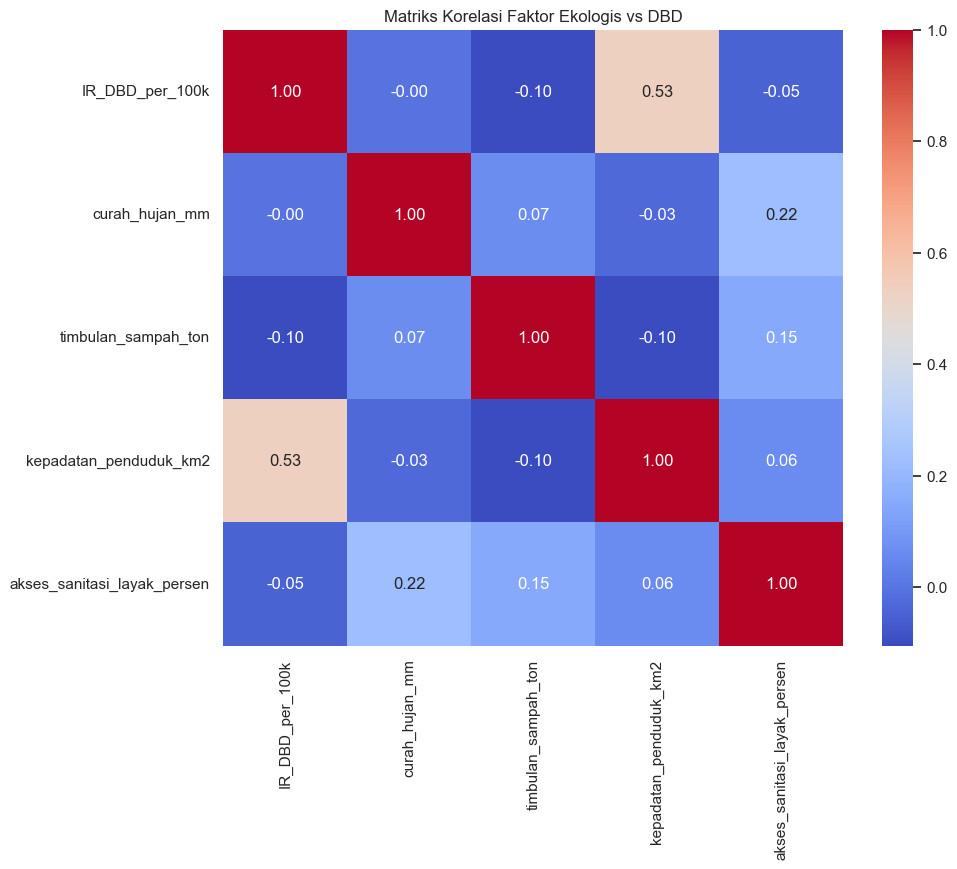

In [7]:
# --- EDA: Korelasi Faktor Ekologis vs DBD ---
plt.figure(figsize=(10, 8))

# Memastikan kolom target dan fitur tersedia
corr_cols = ['IR_DBD_per_100k', 'curah_hujan_mm', 'timbulan_sampah_ton', 'kepadatan_penduduk_km2', 'akses_sanitasi_layak_persen']

# Menghitung korelasi
sns.heatmap(df_wrangled[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriks Korelasi Faktor Ekologis vs DBD")
plt.show()

Persiapan Data (Shuffling & Blind Test 15 Data)

Di sini kita mengacak data agar model belajar secara adil dan menyisihkan 15 data untuk pengujian akhir yang "terpercaya".

In [8]:
# --- Persiapan Data untuk Machine Learning ---

# 1. Mengacak seluruh data (Shuffling)
df_shuffled = df_wrangled.sample(frac=1, random_state=42).reset_index(drop=True)

# 2. Menyisihkan 15 data terakhir sebagai 'Blind Test' (Data Extra)
df_main = df_shuffled.iloc[:-15]  # Data untuk training & testing normal
df_extra = df_shuffled.iloc[-15:] # 15 data "asing" untuk pembuktian akhir

# 3. Menentukan Fitur (X) dan Target (y)
features = ['curah_hujan_mm', 'timbulan_sampah_ton', 'kepadatan_penduduk_km2', 'akses_sanitasi_layak_persen']
target = 'IR_DBD_per_100k'

X_main = df_main[features]
y_main = df_main[target]
X_extra = df_extra[features]
y_extra = df_extra[target]

print(f"Data Utama: {X_main.shape[0]} baris | Data Extra: {X_extra.shape[0]} baris")

Data Utama: 760 baris | Data Extra: 15 baris


Eksperimen Berbagai Rasio Split (60:40, 70:30, 80:20)

menjalankan eksperimen otomatis untuk mencari rasio mana yang paling stabil menggunakan Random Forest.

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

ratios = [0.4, 0.3, 0.2] # Mewakili 60:40, 70:30, 80:20
results_rf = []

for test_size in ratios:
    # Split data main
    X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=test_size, random_state=42)
    
    # Inisialisasi Model Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Prediksi
    r2_test = r2_score(y_test, model.predict(X_test))
    r2_extra = r2_score(y_extra, model.predict(X_extra))
    
    results_rf.append({
        'Rasio (Train:Test)': f"{int((1-test_size)*100)}:{int(test_size*100)}",
        'R2 Test (Internal)': round(r2_test, 4),
        'R2 Extra (15 Data)': round(r2_extra, 4),
        'Selisih Skor': round(abs(r2_test - r2_extra), 4)
    })

# Tampilkan Tabel Hasil
df_compare = pd.DataFrame(results_rf)
print("--- Hasil Eksperimen Random Forest ---")
display(df_compare)

--- Hasil Eksperimen Random Forest ---


,Rasio (Train:Test),R2 Test (Internal),R2 Extra (15 Data),Selisih Skor
0,60:40,-0.1420,-0.0174,0.1245
1,70:30,0.0777,0.1429,0.0652
2,80:20,0.1278,0.0193,0.1085


Pelatihan Model Final & Visualisasi Akurasi

Gunakan rasio terbaik (70:30) untuk melatih model final dan melihat grafik "Prediksi vs Kenyataan" pada 15 data extra.

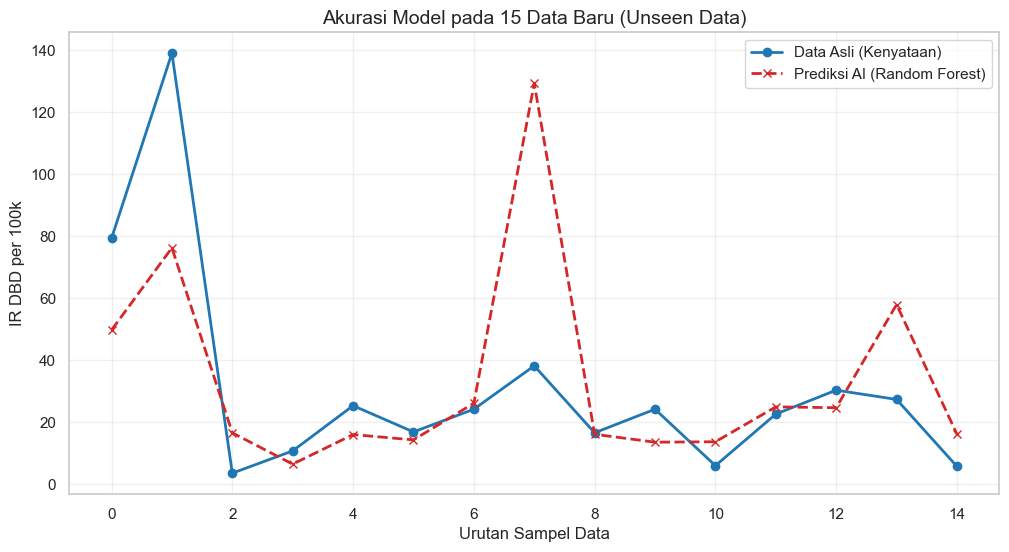

In [10]:
# --- Pelatihan Model Final (Rasio 70:30) ---
X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=0.3, random_state=42)
final_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_model.fit(X_train, y_train)

# Prediksi pada 15 data extra
y_pred_extra = final_model.predict(X_extra)

# Visualisasi Prediksi vs Data Asli
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_extra)), y_extra.values, label='Data Asli (Kenyataan)', marker='o', color='#1f77b4', linewidth=2)
plt.plot(range(len(y_extra)), y_pred_extra, label='Prediksi AI (Random Forest)', marker='x', linestyle='--', color='#d62728', linewidth=2)

plt.title('Akurasi Model pada 15 Data Baru (Unseen Data)', fontsize=14)
plt.xlabel('Urutan Sampel Data')
plt.ylabel('IR DBD per 100k')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Analisis Faktor Paling Berpengaruh (Feature Importance)
Bagian ini menjawab inti penelitian Faktor lingkungan mana yang paling memicu DBD?

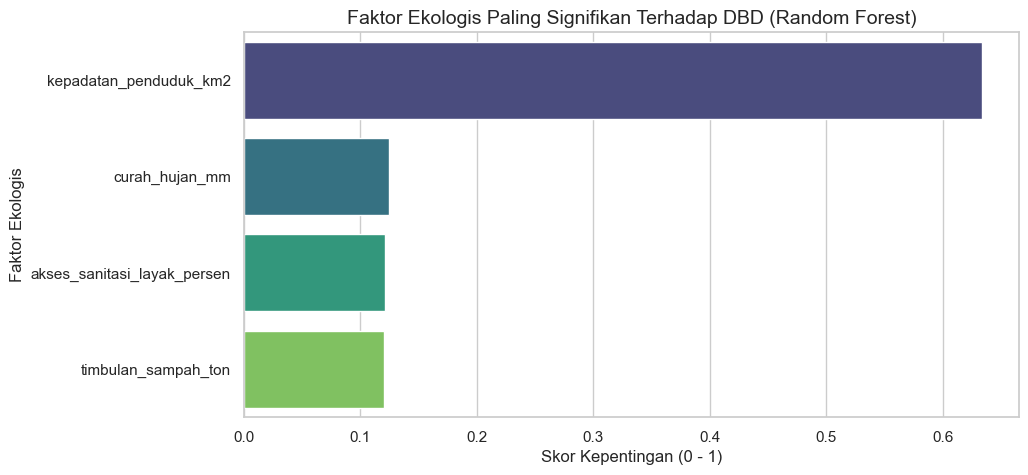

Urutan Variabel yang Menjadi Landasan Strategi Mitigasi:


,Faktor Ekologis,Tingkat Kepentingan
2,kepadatan_penduduk_km2,0.633770
0,curah_hujan_mm,0.124585
3,akses_sanitasi_layak_persen,0.121423
1,timbulan_sampah_ton,0.120222


In [11]:
# --- Identifikasi Variabel Paling Signifikan ---
importances = final_model.feature_importances_
feature_df = pd.DataFrame({'Faktor Ekologis': features, 'Tingkat Kepentingan': importances})
feature_df = feature_df.sort_values(by='Tingkat Kepentingan', ascending=False)

# Plotting Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(x='Tingkat Kepentingan', y='Faktor Ekologis', data=feature_df, palette='viridis')
plt.title('Faktor Ekologis Paling Signifikan Terhadap DBD (Random Forest)', fontsize=14)
plt.xlabel('Skor Kepentingan (0 - 1)')
plt.show()

print("Urutan Variabel yang Menjadi Landasan Strategi Mitigasi:")
display(feature_df)

---

#### **Model Evaluation & Accuracy Analysis**

Mengukur kinerja model menggunakan data uji yang belum pernah dilihat sebelumnya.Mengetahui akurasi model ($R^2$ Score) dan rata-rata tingkat kesalahan (MAE).

---

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Melakukan prediksi pada kedua set data
y_pred_test = final_model.predict(X_test)
y_pred_extra = final_model.predict(X_extra)

# 2. Perhitungan Metrik
results_eval = {
    "Metrik": ["R2 Score", "MAE (Mean Absolute Error)", "RMSE (Root Mean Squared Error)"],
    "Data Testing (Internal)": [
        r2_score(y_test, y_pred_test),
        mean_absolute_error(y_test, y_pred_test),
        np.sqrt(mean_squared_error(y_test, y_pred_test))
    ],
    "Data Extra (15 Data Baru)": [
        r2_score(y_extra, y_pred_extra),
        mean_absolute_error(y_extra, y_pred_extra),
        np.sqrt(mean_squared_error(y_extra, y_pred_extra))
    ]
}

df_eval = pd.DataFrame(results_eval)
print("--- Tabel Evaluasi Performa Model ---")
display(df_eval)

--- Tabel Evaluasi Performa Model ---


,Metrik,Data Testing (Internal),Data Extra (15 Data Baru)
0,R2 Score,0.077718,0.142882
1,MAE (Mean Absolute Error),32.164778,18.803470
2,RMSE (Root Mean Squared Error),46.505806,31.220363


---

#### **Residual Analysis (Analisis Galat)**

Analisis selisih antara nilai aktual dan prediksi. Mengukur sejauh mana model "meleset" dalam memprediksi angka morbiditas.

---

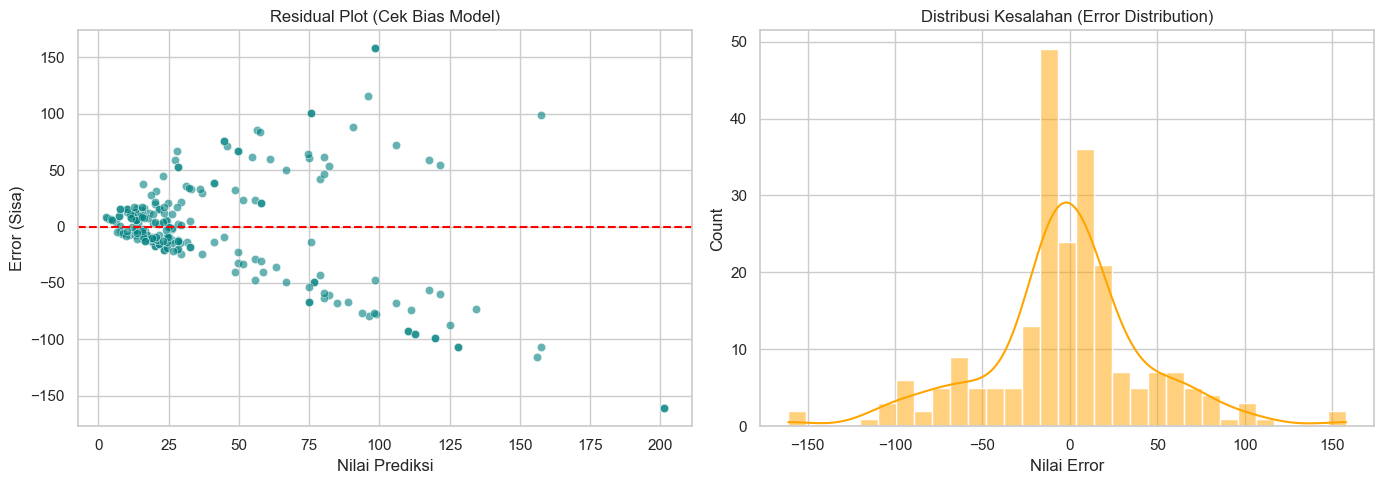

In [13]:
# Menghitung selisih antara nilai asli dan prediksi (Residual)
residuals = y_test - y_pred_test

plt.figure(figsize=(14, 5))

# Plot 1: Sebaran Error
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_test, y=residuals, color='teal', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot (Cek Bias Model)')
plt.xlabel('Nilai Prediksi')
plt.ylabel('Error (Sisa)')

# Plot 2: Distribusi Error (Normalitas)
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='orange')
plt.title('Distribusi Kesalahan (Error Distribution)')
plt.xlabel('Nilai Error')

plt.tight_layout()
plt.show()

In [21]:
# 1. Pastikan kolom bersih dan buat file CSV untuk database Streamlit
df_wrangled.columns = df_wrangled.columns.str.strip()
df_wrangled.to_csv('df_gabungan.csv', index=False)

# 2. Mengacak data dan menyisihkan 15 data untuk pengujian extra
df_shuffled = df_wrangled.sample(frac=1, random_state=42).reset_index(drop=True)
df_main = df_shuffled.iloc[:-15]
df_extra = df_shuffled.iloc[-15:]

print("✅ File 'df_gabungan.csv' berhasil dibuat untuk database wilayah.")

✅ File 'df_gabungan.csv' berhasil dibuat untuk database wilayah.


In [22]:
import joblib
from sklearn.ensemble import RandomForestRegressor

# Tentukan fitur sesuai urutan di Streamlit
features = ['curah_hujan_mm', 'timbulan_sampah_ton', 'kepadatan_penduduk_km2', 'akses_sanitasi_layak_persen']
X = df_main[features]
y = df_main['IR_DBD_per_100k']

# Latih model final (Rasio 70:30 atau 80:20 bisa Anda sesuaikan)
model_final = RandomForestRegressor(n_estimators=100, random_state=42)
model_final.fit(X, y)

# EXPORT: Simpan model dan daftar fitur agar app.py bisa membacanya
joblib.dump(model_final, 'model_dbd_rf.pkl')
joblib.dump(features, 'features_list.pkl')

print("✅ File 'model_dbd_rf.pkl' dan 'features_list.pkl' berhasil dibuat.")

✅ File 'model_dbd_rf.pkl' dan 'features_list.pkl' berhasil dibuat.


In [23]:
from sklearn.metrics import r2_score, mean_absolute_error

# Prediksi pada 15 data extra yang belum pernah dilihat model
y_pred_extra = model_final.predict(df_extra[features])

# Hitung skor
r2 = r2_score(df_extra['IR_DBD_per_100k'], y_pred_extra)
mae = mean_absolute_error(df_extra['IR_DBD_per_100k'], y_pred_extra)

print(f"--- Evaluasi Model ---")
print(f"R2 Score (Akurasi): {r2:.4f}")
print(f"MAE (Rerata Error): {mae:.4f}")

--- Evaluasi Model ---
R2 Score (Akurasi): -0.0174
MAE (Rerata Error): 20.7670


---

#### **Membuat File App.py Untuk Streamlite**

---

In [25]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# 1. KONFIGURASI HALAMAN
st.set_page_config(page_title="Monitoring Pencegahan DBD", page_icon="🛡️", layout="wide")

# Style CSS Profesional
st.markdown("""
    <style>
    .main { background-color: #f4f7f6; }
    h1, h2, h3 { color: #1b5e20; font-weight: bold; }
    .stMetric { background-color: #ffffff; padding: 15px; border-radius: 10px; border-left: 10px solid #2e7d32; }
    </style>
    """, unsafe_allow_html=True)

# 2. LOAD DATA OTOMATIS
@st.cache_data
def load_automated_data():
    try:
        model = joblib.load('model_dbd_rf.pkl')
        features = joblib.load('features_list.pkl')
        df = pd.read_csv('df_gabungan.csv')
        return model, features, df
    except Exception as e:
        st.error(f"Gagal memuat data: {e}")
        return None, None, None

model, features, df_master = load_automated_data()

st.title("🛡️ Sistem Otomatis Strategi Pencegahan DBD")
st.markdown("---")

if df_master is not None:
    st.sidebar.title("📍 Pilih Wilayah")
    list_kota = sorted(df_master['Kabupaten/Kota'].unique())
    selected_kota = st.sidebar.selectbox("Pilih Kabupaten/Kota:", list_kota)

    # Ambil data terbaru otomatis
    data_terbaru = df_master[df_master['Kabupaten/Kota'] == selected_kota].iloc[-1]
    
    st.subheader(f"📊 Kondisi Ekologis Terkini: {selected_kota} (Tahun {int(data_terbaru['Tahun'])})")
    
    c1, c2, c3, c4 = st.columns(4)
    hujan_val = data_terbaru['curah_hujan_mm']
    sampah_val = data_terbaru['timbulan_sampah_ton']
    kepadatan_val = data_terbaru['kepadatan_penduduk_km2']
    sanitasi_val = data_terbaru['akses_sanitasi_layak_persen']

    c1.metric("Curah Hujan", f"{hujan_val:.0f} mm")
    c2.metric("Sampah", f"{sampah_val:,.0f} Ton")
    c3.metric("Kepadatan", f"{kepadatan_val:,.0f} Jiwa/km²")
    c4.metric("Sanitasi", f"{sanitasi_val:.1f}%")

    st.markdown("---")
    st.header("🎯 Rekomendasi Langkah Pencegahan Strategis")
    
    col_l, col_r = st.columns(2)
    with col_l:
        st.success("#### 🌧️ Mitigasi Dampak Curah Hujan")
        # Sesuaikan threshold 2000 dengan skala data asli Anda
        if hujan_val > 2000:
            st.write("**Metode: PSN 3M Plus Intensif**")
            st.write("- **Kuras:** Minimal 2x seminggu.")
            st.write("- **Tutup:** Tandon air harus rapat.")
        else:
            st.write("- Fokus pada pembersihan wadah air indoor.")

    with col_r:
        st.success("#### 👥 Pencegahan Area Padat")
        # Sesuaikan threshold 1200 dengan skala data asli Anda
        if kepadatan_val > 1200:
            st.write("**Metode: Gerakan G1W1J**")
            st.write("- **G1W1J:** 1 Rumah 1 Jumantik mandiri.")
            st.write("- **Fisik:** Pasang kawat nyamuk pada ventilasi.")

Overwriting app.py


In [ ]:
!streamlit run app.py